In [38]:
%load_ext autoreload
%autoreload 2

from matplotlib import colors
from scipy.stats import truncnorm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Data Generation

NUM_STUDENTS = 30
MEAN = 80
STD = 20

# https://stackoverflow.com/questions/36894191/how-to-get-a-normal-distribution-within-a-range-in-numpy
# Need to cap the values of the distributions to [0,100]
def get_truncated_normal(mean, sd, size, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs(size)

grades_GT = get_truncated_normal(MEAN, STD, NUM_STUDENTS, 0, 100)
grades_P = get_truncated_normal(MEAN, STD, NUM_STUDENTS, 0, 100)

mean_squared_error:  465.74
mean_absolute_error:  16.49
explained_variance_score:  -1.68


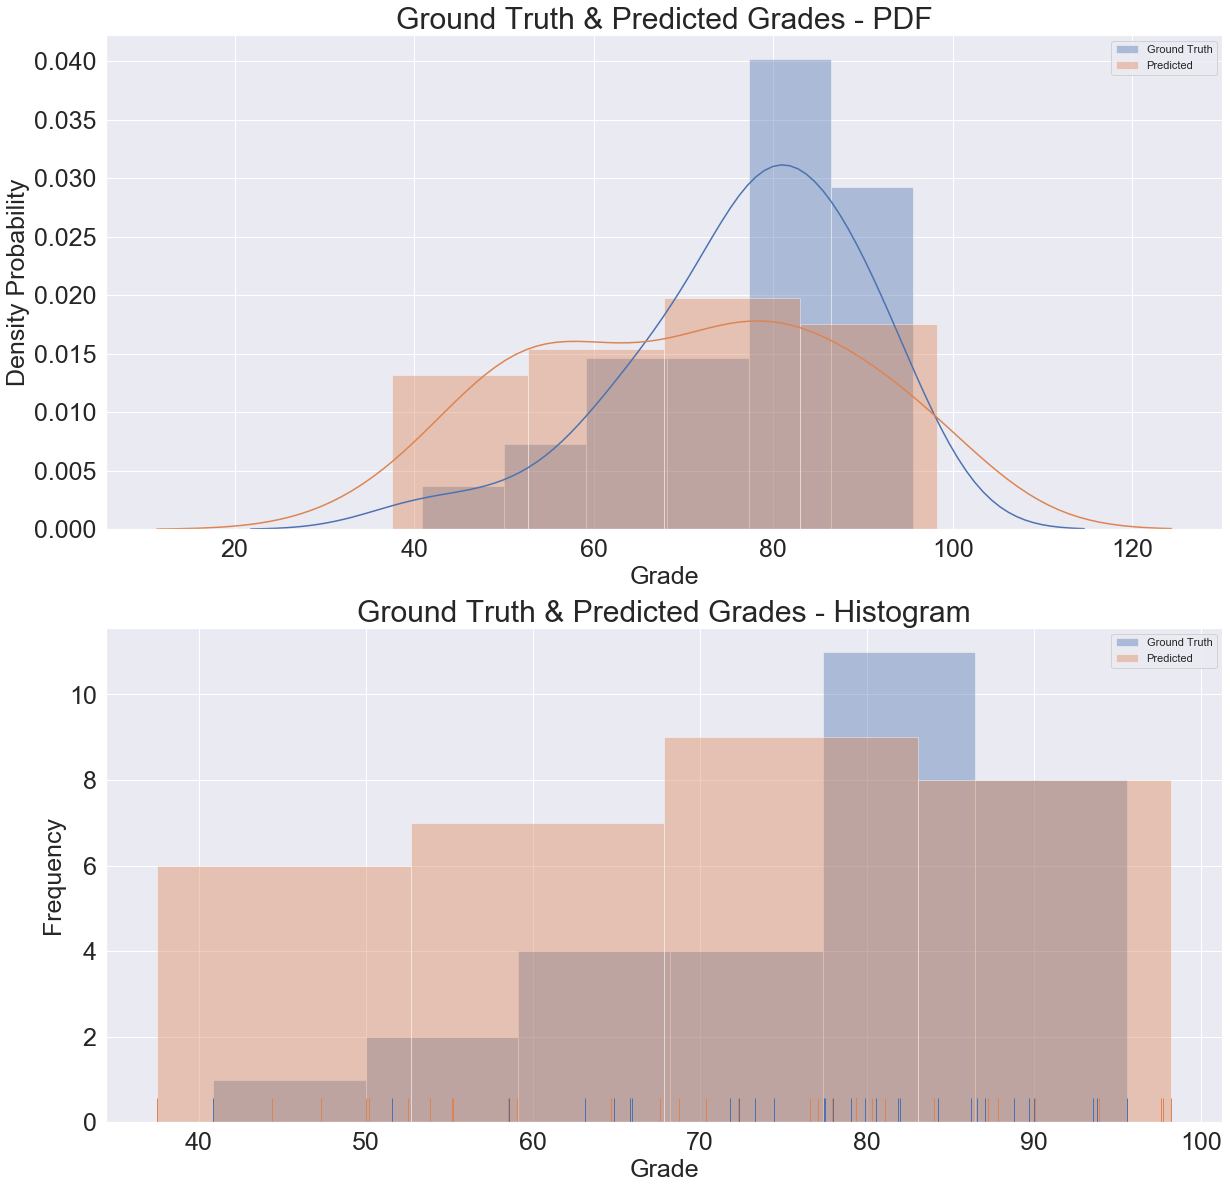

In [40]:
# Regression Analysis

fig, ax = plt.subplots(2, 1, figsize=(20,20))
sns.set(color_codes=True)

print("mean_squared_error: ", round(mean_squared_error(grades_GT, grades_P), 2))
print("mean_absolute_error: ", round(mean_absolute_error(grades_GT, grades_P), 2))
print("explained_variance_score: ", round(explained_variance_score(grades_GT, grades_P), 2))

sns.distplot(grades_GT, kde=True, rug=False, ax=ax[0], label="Ground Truth")
sns.distplot(grades_P, kde=True, rug=False, ax=ax[0], label="Predicted")
ax[0].tick_params(axis='both', labelsize=25)
ax[0].set_title("Ground Truth & Predicted Grades - PDF")
ax[0].title.set_size(30)
ax[0].set_xlabel("Grade", fontsize=25)
ax[0].set_ylabel("Density Probability", fontsize=25)
ax[0].legend()

sns.distplot(grades_GT, kde=False, rug=True, ax=ax[1], label="Ground Truth")
sns.distplot(grades_P, kde=False, rug=True, ax=ax[1], label="Predicted")
ax[1].tick_params(axis='both', labelsize=25)
ax[1].set_title("Ground Truth & Predicted Grades - Histogram")
ax[1].title.set_size(30)
ax[1].set_xlabel("Grade", fontsize=25)
ax[1].set_ylabel("Frequency", fontsize=25)
ax[1].legend()

In [41]:
def create_joint_probability_matrix(data_GT, data_P, bins):

    # https://stackoverflow.com/questions/38931566
    def background_gradient(s, m=None, M=None, cmap='Reds', low=0, high=0):
        if m is None:
            m = s.min().min()
        if M is None:
            M = s.max().max()
        rng = M - m
        norm = colors.Normalize(m - (rng * low), M + (rng * high))
        normed = s.apply(lambda x: norm(x.values))
        cm = plt.cm.get_cmap(cmap)
        c = normed.applymap(lambda x: colors.rgb2hex(cm(x)))
        ret = c.applymap(lambda x: 'background-color: %s' % x)
        return ret
    
    assert(len(data_GT) == len(data_P))
    
    bucket_GT = pd.cut(data_GT, bins=bins, include_lowest=True, right=True)
    bucket_P = pd.cut(data_P, bins=bins, include_lowest=True, right=True)

    # Generate a pandas dataframe where the index represents the student number
    df_GT = pd.DataFrame({'bucket': bucket_GT}).reset_index()
    df_P = pd.DataFrame({'bucket': bucket_P}).reset_index()

    # Merged the actual predicted grades 
    merged_df = pd.merge(df_GT, df_P, on=['index'], suffixes=('_grouth_truth', '_predicted'))

    # Create a multi-leveled
    merged_df = merged_df.groupby(['bucket_grouth_truth', 'bucket_predicted']).count()

    # https://stackoverflow.com/a/43921476/768439
    # Convert multi-leveled pandas index into a 2d numpy array
    m, n = len(merged_df.index.levels[0]), len(merged_df.index.levels[1])
    jp_matrix = merged_df.values.reshape(m, n)
    
    # Convert counts to percentages
    bin_size = (bins[1] - bins[0])
    total = len(data_GT)  # equal to len(data_P)
    axis = np.linspace(bin_size/2, bins[-1] + bin_size/2, len(bins))[:-1]
    jp_df = pd.DataFrame(jp_matrix, columns=axis, index=axis)
    jp_df = jp_df.applymap(lambda val: 0 if math.isnan(val) else (val / len(data_GT)))
    
    # Format the output table
    jp_df.columns.name = 'Predicted'
    jp_df.index.name = 'Ground Truth'
    formatted_df = jp_df.style.set_caption("Probability Distribution Matrix").apply(background_gradient, high=1, axis=None).format("{:.2f}")
    
    return formatted_df

In [42]:
NUM_BINS = 10
bins = np.linspace(0, 100, NUM_BINS + 1)

In [43]:
create_joint_probability_matrix(grades_GT, grades_P, bins)

Predicted,5.0,15.0,25.0,35.0,45.0,55.0,65.0,75.0,85.0,95.0
Ground Truth,,,,,,,,,,
5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
35.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
45.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00
55.0,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00
65.0,0.00,0.00,0.00,0.00,0.00,0.03,0.07,0.00,0.03,0.00
75.0,0.00,0.00,0.00,0.03,0.00,0.07,0.03,0.13,0.00,0.07
85.0,0.00,0.00,0.00,0.00,0.07,0.03,0.00,0.07,0.07,0.10


In [44]:
create_joint_probability_matrix(grades_GT, grades_GT, bins)

Predicted,5.0,15.0,25.0,35.0,45.0,55.0,65.0,75.0,85.0,95.0
Ground Truth,,,,,,,,,,
5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
35.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
45.0,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00
55.0,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00
65.0,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.00,0.00,0.00
75.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.00,0.00
85.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.00


In [45]:
# Note: we set include_lowest to true to make sure that we include zeroes
bucket_GT = pd.cut(grades_GT, bins=bins, include_lowest=True, right=True)
bucket_P = pd.cut(grades_P, bins=bins, include_lowest=True, right=True)

# Output of the cut function
pd.DataFrame({'grades': grades_GT, 'bucket': bucket_GT}).head()

,grades,bucket
0,89.967769,"(80.0, 90.0]"
1,65.905052,"(60.0, 70.0]"
2,65.785778,"(60.0, 70.0]"
3,74.420973,"(70.0, 80.0]"
4,58.598503,"(50.0, 60.0]"


In [46]:
# Generate a pandas dataframe where the index represents the student number
df_GT = pd.DataFrame({'bucket': bucket_GT}).reset_index()
display(df_GT.head())

df_P = pd.DataFrame({'bucket': bucket_P}).reset_index()
display(df_P.head())

# Merged the actual predicted grades 
merged_df = pd.merge(df_GT, df_P, on=['index'], suffixes=('_grouth_truth', '_predicted'))
display(merged_df.head())

# Create a multi-leveled
merged_df = merged_df.groupby(['bucket_grouth_truth', 'bucket_predicted']).count()
display(merged_df.head())

# Taken from: https://stackoverflow.com/a/43921476/768439
# Convert multi-leveled pandas index into a 2d numpy array
m, n = len(merged_df.index.levels[0]), len(merged_df.index.levels[1])
jp_matrix = merged_df.values.reshape(m, n)

,index,bucket
0,0,"(80.0, 90.0]"
1,1,"(60.0, 70.0]"
2,2,"(60.0, 70.0]"
3,3,"(70.0, 80.0]"
4,4,"(50.0, 60.0]"


,index,bucket
0,0,"(40.0, 50.0]"
1,1,"(50.0, 60.0]"
2,2,"(60.0, 70.0]"
3,3,"(30.0, 40.0]"
4,4,"(50.0, 60.0]"


,index,bucket_grouth_truth,bucket_predicted
0,0,"(80.0, 90.0]","(40.0, 50.0]"
1,1,"(60.0, 70.0]","(50.0, 60.0]"
2,2,"(60.0, 70.0]","(60.0, 70.0]"
3,3,"(70.0, 80.0]","(30.0, 40.0]"
4,4,"(50.0, 60.0]","(50.0, 60.0]"


index
bucket_grouth_truth bucket_predicted       
(-0.001, 10.0]      (-0.001, 10.0]      NaN
                    (10.0, 20.0]        NaN
                    (20.0, 30.0]        NaN
                    (30.0, 40.0]        NaN
                    (40.0, 50.0]        NaN

In [47]:
axis = np.linspace(5, 105, NUM_BINS + 1)[:-1]
jp_df = pd.DataFrame(jp_matrix, columns=axis, index=axis)
jp_df = jp_df.applymap(lambda val: 0 if math.isnan(val) else (val / NUM_STUDENTS))
jp_df

,5.0,15.0,25.0,35.0,45.0,55.0,65.0,75.0,85.0,95.0
5.0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15.0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25.0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35.0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45.0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000
55.0,0,0,0,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000
65.0,0,0,0,0.000000,0.000000,0.033333,0.066667,0.000000,0.033333,0.000000
75.0,0,0,0,0.033333,0.000000,0.066667,0.033333,0.133333,0.000000,0.066667
85.0,0,0,0,0.000000,0.066667,0.033333,0.000000,0.066667,0.066667,0.100000
95.0,0,0,0,0.000000,0.033333,0.033333,0.000000,0.000000,0.033333,0.000000


In [48]:
# https://stackoverflow.com/questions/38931566
def background_gradient(s, m=None, M=None, cmap='Reds', low=0, high=0):
    if m is None:
        m = s.min().min()
    if M is None:
        M = s.max().max()
    rng = M - m
    norm = colors.Normalize(m - (rng * low), M + (rng * high))
    normed = s.apply(lambda x: norm(x.values))
    cm = plt.cm.get_cmap(cmap)
    c = normed.applymap(lambda x: colors.rgb2hex(cm(x)))
    ret = c.applymap(lambda x: 'background-color: %s' % x)
    return ret

jp_df.columns.name = 'Predicted'
jp_df.index.name = 'Ground Truth'
jp_df.style.set_caption("Joint Probability Matrix").apply(background_gradient, high=1, axis=None).format("{:.2f}")

Predicted,5.0,15.0,25.0,35.0,45.0,55.0,65.0,75.0,85.0,95.0
Ground Truth,,,,,,,,,,
5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
35.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
45.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00
55.0,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00
65.0,0.00,0.00,0.00,0.00,0.00,0.03,0.07,0.00,0.03,0.00
75.0,0.00,0.00,0.00,0.03,0.00,0.07,0.03,0.13,0.00,0.07
85.0,0.00,0.00,0.00,0.00,0.07,0.03,0.00,0.07,0.07,0.10
